<a href="https://colab.research.google.com/github/Fantiflex/Modular_Manifold_Muon/blob/main/Fantine_q_coding_muon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Problem Intro

In this problem, we will implement key components of the Muon optimizer in PyTorch. Then,  we will compare Muon against SGD and AdamW empirically to demonstrate the benefits of Muon.

We will train a sample CNN architecture on CIFAR10 image data (initialized below).

In [ ]:
# Define a sample CNN for CIFAR-10
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Dataset & loader with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Increase batch size for more realistic training
batch_size = 128

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


## Part 1: Implementing Newton-Schulz

The core of Muon is using matrix orthogonalization on a typical gradient update matrix. After orthogonalization:
* Singular values become more uniform
* Updates act across all directions in parameter space
* The neural network can utilize its full parameter capacity (because parameters are all receiving nontrivial gradients)

In Muon, matrix orthogonalization is done using Newton-Schulz. Newton-Schulz relies on iteration using an odd matrix polynomial. In this problem, we consider a very simple cubic polynomial, but many odd polynomials can be used (state-of-the-art implementations use specific, tuned quintic polynomial).

**Complete the following code** to implement Newton-Schulz, using the matrix polynomial in the comments.


In [ ]:
def newton_schulz_orthogonalize(X: torch.Tensor, num_iters: int):
    """
    Apply Newton-Schulz iterations to approximate orthogonalization.

    This function applies the polynomial f(X) = (3X - X^3)/2 repeatedly to a normalized matrix,
    which gradually forces all singular values to 1 while preserving singular vectors.

    Args:
      X (torch.Tensor): Input matrix to orthogonalize
      num_iters (int): Number of Newton-Schulz iterations

    Returns:
      torch.Tensor: Orthogonalized matrix
    """
    dtype = X.dtype
    # Use bfloat16 for potential speed/memory savings during the iterations
    X = X.bfloat16()
    # Recall from prior homeworks that we can transpose the matrix to speed up computation.
    transposed = False
    if X.size(-2) < X.size(-1):
        transposed = True
        X = X.mT

    # Ensure spectral norm is at most sqrt(3)
    norm = torch.linalg.norm(X, dim=(-2, -1), keepdim=True)
    X = torch.div(X, norm + 1e-7) * (3**0.5)

    ################################################################################
    # TODO: YOUR CODE HERE
    ################################################################################
    ################################################################################

    if transposed:
        X = X.mT

    return X.to(dtype)

### Question 1

Notice that in the above implementation, we scale the spectral norm to be at most sqrt(3). **Can you explain why we choose this particular scaling?**

*(Hint: Inspect the roots of the cubic polynomial. What is the connection between the roots and the convergence properties of the singular values? You can refer to Discussion 4 for the answer)*

## Part 2: Implementing Muon Update

Now, we implement the update in a Muon optimizer. Given parameter matrix $W$ with momentum matrix $M$, the pseudocode for the Muon update proceeds as follows:

```
d_out, d_in = M.shape

# Apply Newton-Schulz orthogonalization
M ← newton_schulz_orthogonalize(M, ns_iters)
        
# Apply muP scaling factor for consistent update magnitude
M ← M · sqrt(max(1, d_out / d_in))
```

Then, the Muon update is used later to update the parameters W:
```
# Update the parameter matrix
W  ← W - lr * M
```

**Complete the following code** to implement the Muon update following the above pseudocode.

In [ ]:
import torch.optim as optim

def muon_update(grad, momentum, beta=0.95, ns_iters=5):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    ################################################################################
    # TODO: YOUR CODE HERE
    ################################################################################
    ################################################################################

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update


class Muon(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, ns_iters=5,
                weight_decay=0):

        defaults = dict(lr=lr, beta=beta, ns_iters=ns_iters,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            ns_iters = group['ns_iters']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply newton_schulz if parameter is a matrix
                if p.ndim >= 2:
                    update = muon_update(grad, state['momentum'],
                                         beta=beta, ns_iters=ns_iters)
                    # Apply update to parameters
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, i.e. bias, use standard momentum update
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return None

### Question 2

Note that Muon requires that parameters are 2D matrices of shape $d_{out} \times d_{in}$. However, we know that parameters that are convolutional kernels have shape $c_{out} \times c_{in} \times k \times k$ where $c$ denotes number of channels and $k$ is kernel size.

Modern implementations of convolutional layers will transform an input image $\mathbf{x}$ of shape $c_{in} \times h \times w$ to $\mathbf{x}'$ such that each column has size $c_{in} \cdot k \cdot k$ and corresponds to one flattened "receptive field" of the image (or one patch of the image that a convolutional filter passes over to compute one pixel in the output).

Given this fact, **how do we modify the convolutional kernel into a $d_{out} \times d_{in}$ matrix $C$ such that the output of the convolutional layer can be expressed as $C \mathbf{x}'$**.


## Part 3: Empirical Evaluation of Muon




Now, we'll train the CNN network on the CIFAR10 dataset using our Muon implementation, comparing performance on the test set against other popular optimizers in SGD and AdamW.

First, in addition to SGD and AdamW, we consider two additional baseline optimizers that will help us better interpret our results:


*   MuonSVD: Rather than using Newton-Schulz, we orthogonalize the momentum using SVD on the momentum matrix $M = U\Sigma V^T$ and computing $UV^T$.
*   AdamWMuP: We add the muP scaling on top of the AdamW optimizer. This is meant the help us better understand how much of the Muon performance is due to the orthogonalization step, and how much is simply from the muP scaling.

The cell below implements these two additional optimizers. You do not have to implement anything.





In [ ]:
import torch.optim as optim

def muon_update_svd(grad, momentum, beta=0.95):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    # Orthogonalization via SVD - specify full_matrices=False for reduced SVD
    U, _, Vh = torch.linalg.svd(update, full_matrices=False)
    update = torch.matmul(U, Vh)

    # Apply muP scaling
    update.mul_(max(1, update.size(-2) / update.size(-1))**0.5)

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update


class MuonSVD(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, weight_decay=0):

        defaults = dict(lr=lr, beta=beta, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply newton_schulz if parameter is a matrix
                if p.ndim >= 2:
                    update = muon_update_svd(grad, state['momentum'], beta=beta)
                    # Apply update to parameters
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, i.e. bias, use standard momentum update
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return None


class AdamWMuP(optim.Optimizer):
    def __init__(self,  params, lr=0.01, betas=(0.9, 0.999), weight_decay=0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']

            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1 - group["betas"][0])
                v = state['variance']
                v.lerp_(grad**2, 1 - group["betas"][1])

                m_hat = m / (1 - group["betas"][0]**state['step'])
                v_hat = v / (1 - group["betas"][1]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                if p.ndim >= 2:
                    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
                    original_shape = u.shape
                    reshaped = False
                    if u.ndim > 2:
                        u = u.view(u.shape[0], -1)  # keep first dim, flatten the rest
                        reshaped = True

                    u.mul_(max(1, u.size(-2) / u.size(-1))**0.5)

                    # Unflatten back to convolutional kernel
                    if reshaped:
                        u = u.view(original_shape)

                p.add_(u, alpha=-lr)

        return None


If you performed hyperparameter sweeping (optional part below), then replace the default hyperparameters with the values you found from your sweep. Then, run the following cell to investigate how good Muon is relative to other baseline optimizers. The cell should take less than 10 minutes if you use a GPU runtime on Colab.


--- Training with Muon ---
Epoch [1/5], Step [100/391], Loss: 2.2731
Epoch [1/5], Step [200/391], Loss: 2.2042
Epoch [1/5], Step [300/391], Loss: 2.0763
Muon | Epoch 1, avg loss: 2.2119, test acc: 26.33%, time: 18.91 seconds
Epoch [2/5], Step [100/391], Loss: 2.0760
Epoch [2/5], Step [200/391], Loss: 1.9214
Epoch [2/5], Step [300/391], Loss: 1.8883
Muon | Epoch 2, avg loss: 1.9853, test acc: 33.74%, time: 17.95 seconds
Epoch [3/5], Step [100/391], Loss: 2.0154
Epoch [3/5], Step [200/391], Loss: 1.9876
Epoch [3/5], Step [300/391], Loss: 1.9148
Muon | Epoch 3, avg loss: 1.8702, test acc: 38.36%, time: 17.98 seconds
Epoch [4/5], Step [100/391], Loss: 1.7875
Epoch [4/5], Step [200/391], Loss: 1.7264
Epoch [4/5], Step [300/391], Loss: 1.8080
Muon | Epoch 4, avg loss: 1.7970, test acc: 40.26%, time: 18.19 seconds
Epoch [5/5], Step [100/391], Loss: 1.6059
Epoch [5/5], Step [200/391], Loss: 1.7870
Epoch [5/5], Step [300/391], Loss: 1.6943
Muon | Epoch 5, avg loss: 1.7592, test acc: 41.13%, ti

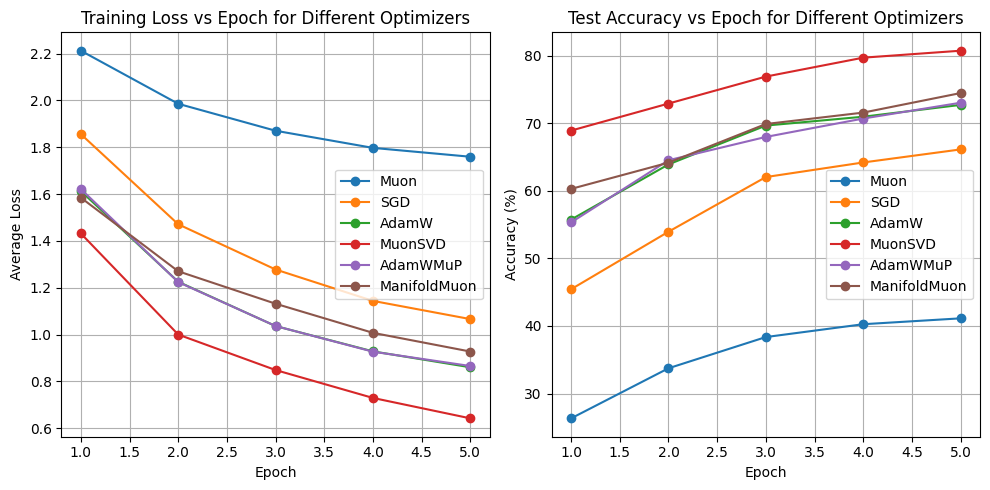

In [ ]:
# --- Define the optimizers you want to compare ---
optimizers_dict = {
    "Muon": lambda params: Muon(params, lr=1e-2, weight_decay=0),
    "SGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=1e-4),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-3),
    "MuonSVD": lambda params: MuonSVD(params, lr=1e-2, weight_decay=0),
    "AdamWMuP": lambda params: AdamWMuP(params, lr=1e-3, weight_decay=1e-3),

    #to uncomment when Manifold Muon is fully implemented:
    "ManifoldMuon": lambda params: ManifoldMuon(params, lr=1e-2, beta=0.95, weight_decay=0),
}

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


results = {}  # store loss curves
accuracy_results = {}  # store accuracy curves

# --- Train for each optimizer ---
for opt_name, opt_fn in optimizers_dict.items():
    print(f"\n--- Training with {opt_name} ---")
    model = CIFAR10CNN().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    losses = []
    accuracies = []
    epoch_times = []

    for epoch in range(1, 6):  # Train for 5 epochs
        model.train()
        epoch_start_time = time.time()
        total_loss = 0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        # Evaluate
        test_acc = evaluate(model, test_loader)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracies.append(test_acc)

        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, test acc: {test_acc:.2f}%, time: {epoch_duration:.2f} seconds")

        # Update learning rate
        scheduler.step()

    results[opt_name] = losses
    accuracy_results[opt_name] = accuracies

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Accuracy vs Epoch
plt.subplot(1, 2, 2)
for opt_name, accuracies in accuracy_results.items():
    plt.plot(range(1, len(accuracies)+1), accuracies, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Question 3

**Which optimizer performed best between Muon, SGD, and AdamW?** Also **copy the resulting plots** into the submission as well.

### Question 4

Compare the loss curves between Muon and MuonSVD. **Are the results expected? Explain why.**

### Question 5

The Muon optimizer contains two key differences: (1) orthogonalization of the momentum, and (2) muP scaling of the momentum. **Between orthogonalization and muP scaling, which seemed to matter more?** Reference the loss curves to justify your answer.  

### Question 6 (Optional)

Our implementation of Newton-Schulz is suboptimal in the polynomial used for convergence.
The community has developed quintic polynomials that converge faster while still being efficient. **Implement an improved Newton-Schulz and compare. Comment on the speed advantage of the improved Muon relative to the MuonSVD.**

*(Hint: You can modify the number of iterations by setting the ns_iters parameter in the Muon optimizer)*

## Part 4 (Optional): Hyperparameter sweeps

To ensure that we are making fair comparisons, we will sweep over both learning rate and weight decay for both Muon and AdamW (the likely strongest competing optimizer). We choose these two parameters because empirically, they have the greatest effect on training.

Running the sweep should take less than 1 hour total on a GPU runtime.

In [ ]:
from torch.utils.data import random_split

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def train_and_evaluate(optimizer_fn, lr, weight_decay, num_epochs=5):
    """Trains and evaluates the CIFAR10CNN with a given optimizer and hyperparameters."""
    model = CIFAR10CNN().to(device)
    optimizer = optimizer_fn(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_accuracy = 0

    # Split training data into training and validation sets
    train_size = int(0.8 * len(train_ds))
    val_size = len(train_ds) - train_size
    train_dataset, val_dataset = random_split(train_ds, [train_size, val_size])

    train_loader_split = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


    for epoch in range(1, num_epochs + 1):
        model.train()
        for i, (x, y) in enumerate(train_loader_split):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        val_acc = evaluate(model, val_loader)
        best_accuracy = max(best_accuracy, val_acc)

        scheduler.step()

    return best_accuracy

# Define the optimizers and their hyperparameter search spaces
optimizers_to_sweep = {
    "Muon": {
        "optimizer_fn": lambda params, lr, weight_decay: Muon(params, lr=lr, weight_decay=weight_decay),
        "lr_values": [1e-2, 5e-3, 1e-3, 5e-4],
        "weight_decay_values": [0, 1e-4, 1e-3]
    },
    "AdamW": {
        "optimizer_fn": lambda params, lr, weight_decay: torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay),
        "lr_values": [1e-2, 5e-3, 1e-3, 5e-4],
        "weight_decay_values": [0, 1e-4, 1e-3]
    }
}

results = {}

# Perform the hyperparameter sweep for each optimizer
for opt_name, opt_info in optimizers_to_sweep.items():
    print(f"\n--- Hyperparameter sweep for {opt_name} ---")
    optimizer_fn = opt_info["optimizer_fn"]
    lr_values = opt_info["lr_values"]
    weight_decay_values = opt_info["weight_decay_values"]

    results[opt_name] = {}

    for lr in lr_values:
        for weight_decay in weight_decay_values:
            print(f"Training with lr={lr}, weight_decay={weight_decay}")
            accuracy = train_and_evaluate(optimizer_fn, lr, weight_decay)
            results[opt_name][(lr, weight_decay)] = accuracy
            print(f"Validation Accuracy: {accuracy:.2f}%")

# Print the results and best hyperparameters for each optimizer
print("\n--- Hyperparameter Sweep Results ---")
for opt_name, opt_results in results.items():
    print(f"\n{opt_name}:")
    for (lr, weight_decay), accuracy in opt_results.items():
        print(f"  (lr={lr}, weight_decay={weight_decay}): {accuracy:.2f}%")

    best_params = max(opt_results, key=opt_results.get)
    print(f"Best hyperparameters for {opt_name}: (lr={best_params[0]}, weight_decay={best_params[1]}) with validation accuracy {opt_results[best_params]:.2f}%")


--- Hyperparameter sweep for Muon ---
Training with lr=0.01, weight_decay=0
Validation Accuracy: 36.31%
Training with lr=0.01, weight_decay=0.0001
Validation Accuracy: 36.24%
Training with lr=0.01, weight_decay=0.001


KeyboardInterrupt: 

### Question 7 (Optional)

**What were the best choices for hyperparameters for Muon? What about for AdamW?**

##Part 5 : Using manifold to constrain our learning
We seek to solve the inner Manifold MuOn dual step efficiently and reliably using plain dual ascent. This part is hugely inspired by Jérémy Bernstein's paper "Modular Manifold".


**A bit of context :** Manifold Muon relies on the idea that parameters should be constrained to live on a manifold. In the Modular Manifolds post, Bernstein focuses on the Stiefel manifold: the set of matrices whose columns are orthonormal and therefore have unit condition number. Constraining weights to Stiefel keeps them *“well-conditioned”* throughout training: none of the singular values can blow up or collapse to zero, so the layer neither explodes nor kills directions in the input space.

To optimize on this manifold, Manifold Muon does not just take a standard gradient step and project back. Instead, it explicitly searches for the steepest descent direction inside the tangent space of the manifold, under a spectral-norm constraint on the update.

Concretely, for a weight matrix W and gradient G, manifold Muon solves a small convex problem: find an update A that  

1.   is tangent to the Stiefel manifold at W
2.   has bounded spectral norm
3.   decreases the loss as fast as possible


The “modular” part comes from how this is organized at the network level. Bernstein treats each layer (or block) as a module with three pieces of structure:


1.   a forward map f(w,x)
2.   a manifold where it lives (here Stiefel manifold)
3.   a norm used to measure the size of the update (here spectral norm)




### Spectral norm: how “strong” is a linear layer?

Before we talk about manifolds or fancy optimization, we need a way to measure **how aggressive** a linear layer can be.
Given a weight matrix (W), the **spectral norm** tells us the maximum factor by which (W) can stretch any input vector of unit length. In other words, it is a quantitative measure of the “strength” or **worst-case amplification** of the layer. In this lab, we will use the spectral norm to control both the size of weight matrices and the size of the updates we apply to them, which is a key ingredient behind the Muon and manifold Muon optimizers.


**Implement the function spectral_norm(W)**

In [ ]:
import torch

def spectral_norm(W: torch.Tensor) -> torch.Tensor:
    """
    Compute the spectral norm of a matrix W.
    Args:
        W: 2D tensor of shape (m, n).
    Returns:
        A scalar tensor: the largest singular value of W.
    """
    ################################################################################
    # TODO: YOUR CODE HERE
    ################################################################################
    ################################################################################
    return float(S.max())


### Matrix sign: keep the direction, normalize the strength

Once we know how to measure the “strength” of a matrix with the spectral norm, the next step is to **control** that strength. The matrix sign operator does exactly this. Given a matrix \(M\), we can factor it as $M = U S V^\top$, where \(S\) contains the singular values. The matrix sign


$\mathrm{msign}(M) = U V^\top$

keeps the same singular directions (\(U\) and \(V\)) but replaces all singular values by 1. In other words, it preserves **where** the matrix pushes vectors, but normalizes **how much** it can stretch them. This gives us a convenient way to build updates whose spectral norm is exactly 1, and then scale them by a learning rate $\eta$. In the simplified manifold Muon step later in the lab, we will use `msign` to turn a gradient into a **direction of steepest descent with controlled size** in spectral norm.


**Implement the function msign(M)**

In [ ]:
def msign(M: torch.Tensor) -> torch.Tensor:
    """
    Matrix sign of M based on its SVD: M = U S V^T -> U V^T.
    The result has spectral norm 1 (up to numerical error).
    Args:
        M: 2D tensor of shape (m, n).
    Returns:
        M_sign: 2D tensor of shape (m, n) with all singular values ≈ 1.
    """
    ################################################################################
    # TODO: YOUR CODE HERE
    ################################################################################
    ################################################################################
    return M_sign


**Projection on Stiefel**

Implement the function project_to_stiefel(W) that computes the SVD of W and returns its projection on the Stiefel manifold.

In [ ]:
def project_to_stiefel(W):
    '''
    Project a 2D weight matrix W onto the (column) Stiefel manifold
    W is the weigths matrix, size n_in x n_out
    using the SVD: W = U S V^T  ->  W_proj = U V^T.
    '''
    ################################################################################
    # TODO: YOUR CODE HERE
    ################################################################################
    ################################################################################
    return W_proj

### A simplified manifold Muon step on the Stiefel manifold

Now that we can (i) measure the strength of a matrix with the spectral norm, (ii) normalize a matrix using the matrix sign, and (iii) project weights onto the Stiefel manifold, we can put everything together into a **simplified manifold Muon update**.

We consider a linear layer with weight matrix \(W\) constrained to the Stiefel manifold (its columns are orthonormal). Given the Euclidean gradient $G = \partial \mathcal{L} / \partial W$, we will:

1. Project the gradient onto the **tangent space** of the Stiefel manifold (Riemannian gradient).
2. Normalize this tangent gradient using the **matrix sign**, so that the update has controlled spectral norm.
3. Take a step of size `lr` in that direction.
4. Retract back onto the Stiefel manifold using our `project_to_stiefel` function.

This gives us a toy version of a *manifold Muon* step: an update that both respects the manifold constraint on the weights and has a bounded “strength” in spectral norm.

**Implement this manifold_muon_step function**


In [ ]:
def manifold_muon_step(W: torch.Tensor,
                       G: torch.Tensor,
                       lr: float) -> torch.Tensor:
    """
    One simplified 'manifold Muon' step on the Stiefel manifold.
    Steps:
    1. Compute the Riemannian (tangent) gradient on the Stiefel manifold:
         G_tan = G - W sym(W^T G),
       where sym(A) = 0.5 * (A + A^T).
    2. Normalize this tangent gradient with `msign` to bound its
       spectral norm (Muon-style).
    3. Take a step of size `lr` in that direction.
    4. Retract back onto the Stiefel manifold using `project_to_stiefel`.
    Args:
        W: current weight matrix on (or near) the Stiefel manifold, shape (m, n)
        G: Euclidean gradient dL/dW, same shape as W
        lr: learning rate (float)
    Returns:
        W_new: updated weight matrix on the Stiefel manifold (m, n)
    """
    with torch.no_grad():
        ################################################################################
        # TODO: YOUR CODE HERE
        # ---- 1. Riemannian (tangent) gradient on Stiefel ----
        # ---- 2. Normalize with msign (spectral norm control) ----
        # Turn the tangent gradient into a direction with spectral norm ~ 1
        # ---- 3. Take a step in that direction ----
        # ---- 4. Retract back onto Stiefel ----
        ################################################################################
        ################################################################################
    return W_new

def riemannian_grad_stiefel(W_mat: torch.Tensor,
                            G_mat: torch.Tensor) -> torch.Tensor:
    """
    Riemannian (tangent) gradient on the Stiefel manifold.

    W_mat: (m, n), current weight matrix
    G_mat: (m, n), Euclidean gradient dL/dW

    Returns:
        G_tan: (m, n), tangent gradient
    """
    # A = W^T G
    A = W_mat.T @ G_mat
    # sym(A) = (A + A^T) / 2
    sym_A = 0.5 * (A + A.T)
    # Tangent gradient
    G_tan = G_mat - W_mat @ sym_A
    return G_tan




def manifold_muon_update(W: torch.Tensor,
                         grad: torch.Tensor,
                         momentum: torch.Tensor,
                         beta: float = 0.95) -> torch.Tensor:
    """
    One manifold-Muon-style *direction* for a single parameter tensor W.

    Steps:
    1. Flatten W and grad to a (m, n) matrix if needed.
    2. Compute the Riemannian gradient on the Stiefel manifold.
    3. Apply momentum in the tangent space (exponential moving average).
    4. Apply msign to bound the spectral norm of the update.

    Args:
        W: parameter tensor (>= 2D for matrix/conv kernels)
        grad: gradient tensor, same shape as W
        momentum: momentum buffer, same shape as W
        beta: momentum hyperparameter (0 <= beta < 1)

    Returns:
        update: tensor with same shape as W
    """
    original_shape = W.shape

    # ---- 1. Flatten to (m, n) if needed ----
    reshaped = False
    if W.ndim > 2:
        reshaped = True
        m = W.size(0)
        W_mat   = W.view(m, -1)
        G_mat   = grad.view_as(W_mat)
        M_mat   = momentum.view_as(W_mat)
    else:
        W_mat = W
        G_mat = grad
        M_mat = momentum
    # ---- 2. Riemannian gradient on Stiefel ----
    G_tan = riemannian_grad_stiefel(W_mat, G_mat)
    # ---- 3. Momentum in tangent space ----
    M_mat.lerp_(G_tan, 1 - beta)
    # ---- 4. Matrix sign to bound spectral norm ----
    update_mat = msign(M_mat) # produces a direction with spectral norm ≈ 1

    # ---- 5. Restore original shape if needed ----
    if reshaped:
        update = torch.zeros_like(W)
        update.view_as(update_mat).copy_(update_mat)
    else:
        update = update_mat

    return update

In [ ]:
class ManifoldMuon(optim.Optimizer):
    """
    Simplified manifold Muon optimizer:

    - For matrix-like parameters (ndim >= 2), we:
        * compute a manifold-Muon direction (tangent + msign),
        * take an update step,
        * project back to the Stiefel manifold.

    - For vector-like parameters (bias, etc.), we fall back to
      standard momentum.

    It follows the same style as MuonSVD.
    """

    def __init__(self, params, lr=0.01, beta=0.95, weight_decay=0.0):
        defaults = dict(lr=lr, beta=beta, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            # optional closure for line-search style methods
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad

                # State for this parameter
                state = self.state[p]
                if 'momentum' not in state:
                    # Momentum buffer has same shape as parameter
                    state['momentum'] = torch.zeros_like(p)

                momentum = state['momentum']

                # AdamW-style decoupled weight decay
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # ---- Matrix-like parameters: manifold Muon on Stiefel ----
                if p.ndim >= 2:
                    # Compute update direction in the tangent space
                    update = manifold_muon_update(
                        W=p,
                        grad=grad,
                        momentum=momentum,
                        beta=beta,
                    )

                    # Gradient step
                    p.add_(update, alpha=-lr)

                    # Project back onto Stiefel (on the flattened view)
                    if p.ndim > 2:
                        m = p.size(0)
                        W_mat = p.view(m, -1)
                        W_proj = project_to_stiefel(W_mat)
                        W_mat.copy_(W_proj)
                    else:
                        W_proj = project_to_stiefel(p)
                        p.copy_(W_proj)

                # ---- 1D parameters: standard momentum update ----
                else:
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return loss





**Modify the ploting block at the beginning of the file so that you can compare Manifold MuOn with other optimizers.**

**Question 8:** Which optimizer achieves the lowest training loss after 5 epochs?

**Question 9** : Compare Muon vs MuonSVD.

Which one converges faster in terms of training loss?

Which one achieves better test accuracy?
How might the SVD-based update help explain this behavior?